In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(10,10)})
import matplotlib
#matplotlib.use('agg')
#matplotlib.style.use('ggplot')
import pickle as pkl
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso

In [2]:
def lemma_maker(x, y):
    #print(lemmatizer(x,y)[0])
    return lemmatizer(x,y)[0]

In [3]:
br_to_us=pd.read_excel("Book.xlsx",skiprows=[0])
br_to_us_dict=dict(zip(br_to_us.UK.tolist(),br_to_us.US.tolist()))
spelling_replacement={'modifier':br_to_us_dict,'head':br_to_us_dict}

In [4]:
features_decades = pd.read_csv("/data/dharp/compounding/datasets/Dist_Features.csv", sep = "\t")
features_decades.set_index(["modifier", "head"], inplace = True)
features_decades.head()

1800_local_mi  1810_local_mi  1820_local_mi  \
modifier head                                                         
a_noun   anti_noun           0.001142       0.002555       0.002155   
         archive_noun        0.001142       0.002555       0.002155   
         atom_noun           0.001142       0.002555       0.002155   
         b_noun              0.001456       0.003373       0.002923   
         bachelor_noun       0.001142       0.002555       0.002155   

                        1830_local_mi  1840_local_mi  1850_local_mi  \
modifier head                                                         
a_noun   anti_noun           0.001269       0.002007       0.001578   
         archive_noun        0.001269       0.002007       0.001578   
         atom_noun           0.001269       0.002007       0.001578   
         b_noun              0.002147       0.003212       0.002955   
         bachelor_noun       0.001269       0.002007       0.001578   

                        1860_local_mi  1870_local_mi  1880_local_mi  \
modifier head                                                         
a_noun   anti_noun           0.001597       0.001914       0.001380   
         archive_noun        0.001597       0.001914       0.001380   
         atom_noun           0.001597       0.001914       0.001380   
         b_noun              0.003300       0.003957       0.003458   
         bachelor_noun       0.001597       0.001914       0.001380   

                        1890_local_mi  ...  1910_sim_with_modifier  \
modifier head                          ...                           
a_noun   anti_noun           0.000751  ...                0.000000   
         archive_noun        0.000751  ...                0.000000   
         atom_noun           0.000751  ...                0.000000   
         b_noun              0.003346  ...                0.663953   
         bachelor_noun       0.000751  ...                0.000000   

                        1920_sim_with_modifier  1930_sim_with_modifier  \
modifier head                                                            
a_noun   anti_noun                    0.000000                0.000000   
         archive_noun                 0.000000                0.000000   
         atom_noun                    0.000000                0.066520   
         b_noun                       0.677382                0.669797   
         bachelor_noun                0.000000                0.000000   

                        1940_sim_with_modifier  1950_sim_with_modifier  \
modifier head                                                            
a_noun   anti_noun                    0.000000                0.646610   
         archive_noun                 0.000000                0.000628   
         atom_noun                    0.063386                0.065969   
         b_noun                       0.656647                0.572634   
         bachelor_noun                0.000000                0.000000   

                        1960_sim_with_modifier  1970_sim_with_modifier  \
modifier head                                                            
a_noun   anti_noun                    0.578278                0.415094   
         archive_noun                 0.040404                0.045660   
         atom_noun                    0.073759                0.076736   
         b_noun                       0.484829                0.363207   
         bachelor_noun                0.000000                0.000000   

                        1980_sim_with_modifier  1990_sim_with_modifier  \
modifier head                                                            
a_noun   anti_noun                    0.162228                0.136877   
         archive_noun                 0.015840                0.009595   
         atom_noun                    0.062530                0.052625   
         b_noun                       0.148975                0.132585   
         bachelor_noun                

In [5]:
reddy11_study=pd.read_csv("/data/dharp/compounding/datasets/ijcnlp_compositionality_data/MeanAndDeviations.clean.txt",sep="\t")
#print(reddy11_study.columns)
reddy11_study.columns=['compound','to_divide']
reddy11_study['modifier_mean'],reddy11_study['modifier_std'],reddy11_study['head_mean'],reddy11_study['head_std'],reddy11_study['compound_mean'],reddy11_study['compound_std'],_=reddy11_study.to_divide.str.split(" ",7).str
reddy11_study['modifier'],reddy11_study['head']=reddy11_study['compound'].str.split(" ",2).str
reddy11_study.modifier=reddy11_study.modifier.str[:-2]
reddy11_study['head']=reddy11_study['head'].str[:-2]
reddy11_study.drop(['compound','to_divide'],axis=1,inplace=True)
reddy11_study['modifier']=np.vectorize(lemma_maker)(reddy11_study['modifier'],'noun')
reddy11_study['head']=np.vectorize(lemma_maker)(reddy11_study['head'],'noun')
reddy11_study.replace(spelling_replacement,inplace=True)
reddy11_study['modifier']=reddy11_study['modifier']+"_noun"
reddy11_study['head']=reddy11_study['head']+"_noun"
reddy11_study=reddy11_study.apply(pd.to_numeric, errors='ignore')
#reddy11_study.set_index(['modifier','head'],inplace=True)
reddy11_study.info()
reddy11_study.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 8 columns):
modifier_mean    90 non-null float64
modifier_std     90 non-null float64
head_mean        90 non-null float64
head_std         90 non-null float64
compound_mean    90 non-null float64
compound_std     90 non-null float64
modifier         90 non-null object
head             90 non-null object
dtypes: float64(6), object(2)
memory usage: 5.7+ KB


,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,modifier,head
0,3.866667,1.117537,4.866667,0.339935,4.250000,0.871165,end_noun,user_noun
1,1.607143,1.654848,1.892857,1.496169,1.703704,1.717337,firing_noun,line_noun
2,2.821429,1.964935,4.862069,0.344828,3.827586,1.233693,game_noun,plan_noun
3,4.766667,0.422953,4.862069,0.344828,4.800000,0.476095,application_noun,form_noun
4,0.600000,0.800000,4.586207,1.099129,1.310345,1.020596,snail_noun,mail_noun


In [6]:
merge_df=reddy11_study.merge(features_decades.reset_index(),on=['modifier','head'],how='inner')
merge_df.set_index(["modifier", "head"], inplace = True)
merge_df.info()
merge_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 80 entries, (end_noun, user_noun) to (bank_noun, account_noun)
Columns: 132 entries, modifier_mean to 2000_sim_with_modifier
dtypes: float64(132)
memory usage: 84.0+ KB


,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800_local_mi,1810_local_mi,1820_local_mi,1830_local_mi,...,1910_sim_with_modifier,1920_sim_with_modifier,1930_sim_with_modifier,1940_sim_with_modifier,1950_sim_with_modifier,1960_sim_with_modifier,1970_sim_with_modifier,1980_sim_with_modifier,1990_sim_with_modifier,2000_sim_with_modifier
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_noun,user_noun,3.866667,1.117537,4.866667,0.339935,4.250000,0.871165,0.001142,0.002555,0.002155,0.001269,...,0.000000,0.000000,0.000000,0.189638,0.458542,0.568473,0.542191,0.513664,0.490777,0.465367
firing_noun,line_noun,1.607143,1.654848,1.892857,1.496169,1.703704,1.717337,0.001142,0.002555,0.002155,0.001269,...,0.039911,0.102790,0.035117,0.029947,0.022442,0.025111,0.037736,0.032476,0.027583,0.025672
game_noun,plan_noun,2.821429,1.964935,4.862069,0.344828,3.827586,1.233693,0.001142,0.002555,0.002155,0.001269,...,0.000000,0.000274,0.000000,0.002569,0.021589,0.146909,0.189427,0.211465,0.194438,0.245117
application_noun,form_noun,4.766667,0.422953,4.862069,0.344828,4.800000,0.476095,0.001142,0.002555,0.002155,0.001272,...,0.520395,0.488524,0.425361,0.428391,0.375451,0.325316,0.352539,0.307542,0.293822,0.303618
web_noun,site_noun,2.678571,1.691440,3.933333,1.181336,3.785714,1.205853,0.001881,0.002555,0.002169,0.001269,...,0.023309,0.045876,0.028429,0.021339,0.047156,0.138569,0.160723,0.201672,0.229830,0.193739


In [8]:
merge_df.to_csv('CompoundAware_DecadeAware.csv',sep='\t')

In [17]:
merge_df.columns

Index(['modifier_mean', 'modifier_std', 'head_mean', 'head_std',
       'compound_mean', 'compound_std', '1800_local_mi', '1810_local_mi',
       '1820_local_mi', '1830_local_mi',
       ...
       '1910_sim_with_modifier', '1920_sim_with_modifier',
       '1930_sim_with_modifier', '1940_sim_with_modifier',
       '1950_sim_with_modifier', '1960_sim_with_modifier',
       '1970_sim_with_modifier', '1980_sim_with_modifier',
       '1990_sim_with_modifier', '2000_sim_with_modifier'],
      dtype='object', length=132)

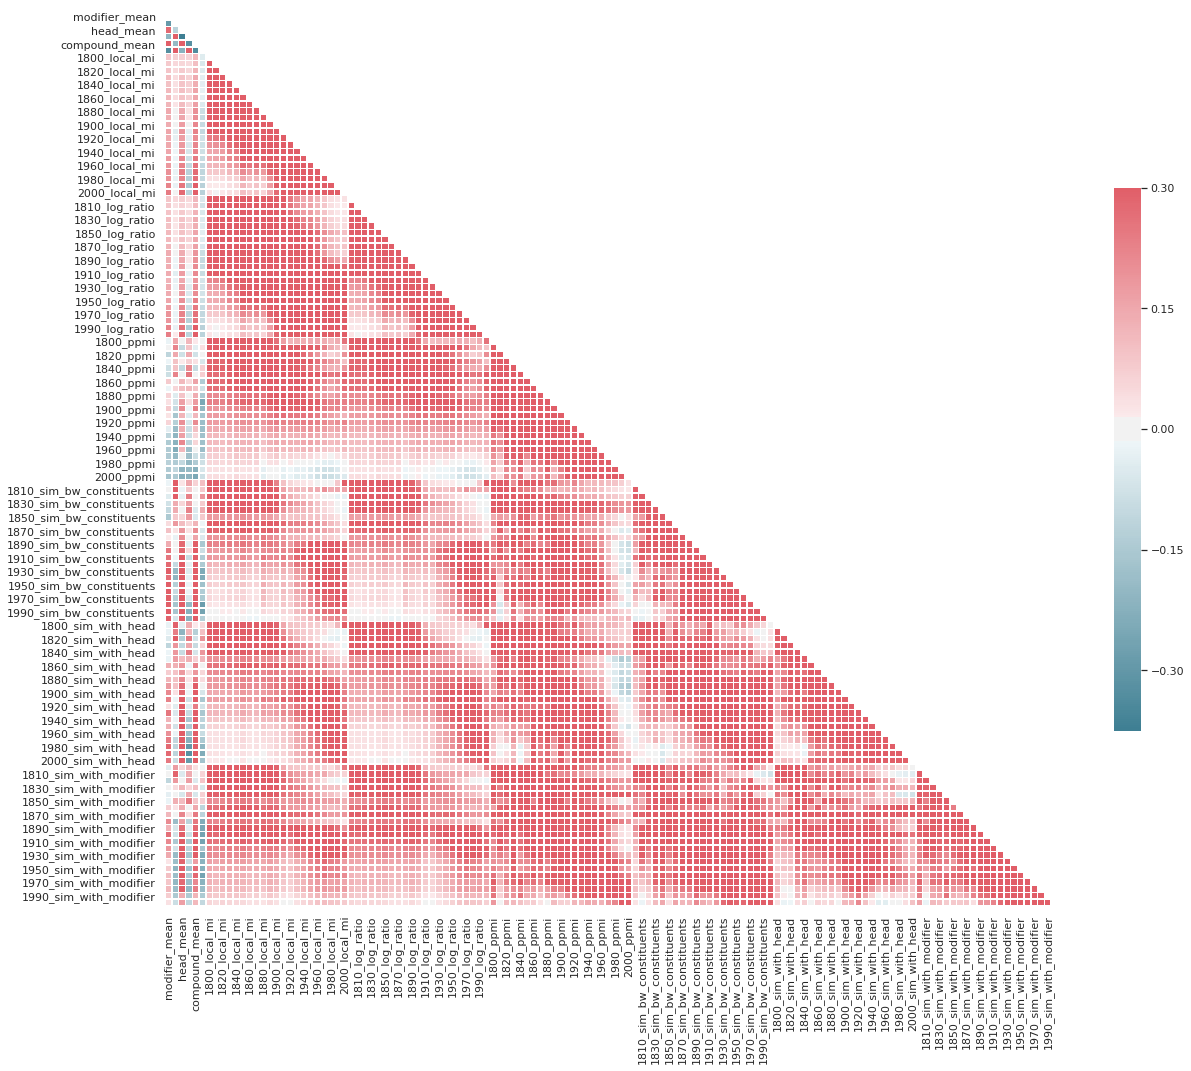

In [13]:
corr=merge_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
X = merge_df.drop(['modifier_mean', 'modifier_std', 'head_mean', 'head_std',
       'compound_mean', 'compound_std'], axis=1)
y_compound = merge_df['compound_mean'].values.reshape(-1,1)

In [21]:
lin_reg = LinearRegression()

MSEs = cross_val_score(lin_reg, X, y_compound, scoring='neg_mean_squared_error', cv=5,verbose=1)

mean_MSE = np.mean(MSEs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [28]:
mean_MSE

-44.9568462072418

In [25]:
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

model = Ridge(normalize=True, alpha=alpha, fit_intercept=True, solver='sparse_cg') #paramters tuned using GridSearchCV
model.fit(x_train_imputer, y_train_array)

#--------------------------USE OUR MODEL TO PREDICT THE Y VALUE OF THE TEST DATA----------------------------------------

prediction = model.predict(x_test_imputer)

#------------------------CREATE AN OUTPUT OF OUR MODELS PREDICTION IN CONTEST FORMAT-----------------------------------

# The only unique thing here is that since we used Log transformation of our Y variable in training the model
# we need to make sure to use np.exp to apply exponential transformation of our predictions so they are back in 
# the format that the original data was in.
output = pd.DataFrame({'id': id_test, 'price_doc': np.exp(prediction)})

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/data/dharp/packages/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.078683e-17
  overwrite_a=False)
/data/dharp/packages/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.491207e-17
  overwrite_a=False)
/data/dharp/packages/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.635433e-17
  overwrite_a=False)
/data/dharp/packages/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solv

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [26]:
ridge_regressor.best_params_

{'alpha': 1}

In [27]:
ridge_regressor.best_score_

-1.668101979811413

In [30]:
lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5,max_iter=10_000)

lasso_regressor.fit(X, y_compound)

TypeError: __init__() got an unexpected keyword argument 'max_iter'